# Predicting House Sale Prices

In this project, we will work with housing data for the city of Ames, Iowa, United States from 2006 to 2010. More information can be read [here](https://www.tandfonline.com/doi/abs/10.1080/10691898.2011.11889627). The goal of this project is to build a prediction model of house sale prices by applying the linear regression algorithm.

Let's start by setting up a **pipline** of functions that will let us quickly iterate on different models:

*train -> transform_features() -> select_features() -> train_and_test() -> rmse_values*

## Data prepration

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [2]:
# read data
data = pd.read_csv('AmesHousing.tsv', delimiter='\t')

In [3]:
def transform_features():
    return train

def select_features():
    return train[['Gr Liv Area', 'SalePrice']]

def train_and_test():
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    """
    Select only numerical columns for train and test data
    """
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    """
    Drop target column -- 'SalePrice' for training and testing processes
    """
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression.fit(numeric_train[features], numeric_train['SalePrice'])
    test_predictions = lr.predict(numeric_test[features])
    mse_test = mean_squared_error(test_predictions, numeric_test['SalePrice'])
    rmse_test = np.sqrt(mse_test)
    
    return rmse_test
    

## Feature engineering

**Update transform_features()** 

The goal of this function:

* remove features that we don't want to use in the model, just based on the number of missing values or data leakage 

* transform features into the proper format (numerical to categorical, scaling numerical, filling in missing values, etc)

* create new features by combining other features


**1. All columns: Drop any with 5% or more missing values for now.**

In [4]:
# check number of missing values in each column
num_missing = data.isnull().sum()
drop_cols_1 = num_missing[num_missing/len(data) > 0.05]
data = data.drop(drop_cols_1.index, axis=1)

**2. Text columns: Drop any with 1 or more missing values for now.**

In [5]:
text_missing = data.select_dtypes(include=['object']).isnull().sum()
drop_cols_2 = text_missing[text_missing>0]
data = data.drop(drop_cols_2.index, axis=1)

**3. Numerical columns: For columns with missing values, fill in with the most common value in that column**

In [6]:
# Find the fixable cols 
num_missing = data.select_dtypes(include=['int', 'float']).isnull().sum()
fixable_numeric_cols = num_missing[(num_missing/len(data)<0.05) & (num_missing>0)].sort_values()
fixable_numeric_cols

BsmtFin SF 1       1
BsmtFin SF 2       1
Bsmt Unf SF        1
Total Bsmt SF      1
Garage Cars        1
Garage Area        1
Bsmt Full Bath     2
Bsmt Half Bath     2
Mas Vnr Area      23
dtype: int64

In [7]:
# Compute the most common values for each column in fixable_numeric_cols
replacement_values_dict = data[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
replacement_values_dict

{'Bsmt Full Bath': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 1': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0,
 'Garage Cars': 2.0,
 'Mas Vnr Area': 0.0,
 'Total Bsmt SF': 0.0}

In [8]:
# replace the fixable cols with the most common values
data = data.fillna(replacement_values_dict)

In [9]:
# Verify every column has 0 missing value
data.isnull().sum().value_counts()

0    64
dtype: int64

**4.New features to create**

In [10]:
years_sold = data['Yr Sold'] - data['Year Built']
years_sold[years_sold < 0]

2180   -1
dtype: int64

In [11]:
year_until_remod = data['Yr Sold'] - data['Year Remod/Add']
year_until_remod[year_until_remod < 0]

1702   -1
2180   -2
2181   -1
dtype: int64

In [12]:
# Drop the above rows with negative values before adding the two new features

# Create new columns
data['Years Before Sale'] = years_sold
data['Years Until Remod'] = year_until_remod

# Drop 
data = data.drop([1702, 2180, 2181], axis=0)

# No need original columns about years

data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)


**5. Drop thoses columns:**
    * are not useful for machine learning
    * Leak data about the final sale

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2927 entries, 0 to 2929
Data columns (total 64 columns):
Order                2927 non-null int64
PID                  2927 non-null int64
MS SubClass          2927 non-null int64
MS Zoning            2927 non-null object
Lot Area             2927 non-null int64
Street               2927 non-null object
Lot Shape            2927 non-null object
Land Contour         2927 non-null object
Utilities            2927 non-null object
Lot Config           2927 non-null object
Land Slope           2927 non-null object
Neighborhood         2927 non-null object
Condition 1          2927 non-null object
Condition 2          2927 non-null object
Bldg Type            2927 non-null object
House Style          2927 non-null object
Overall Qual         2927 non-null int64
Overall Cond         2927 non-null int64
Roof Style           2927 non-null object
Roof Matl            2927 non-null object
Exterior 1st         2927 non-null object
Exterior 2nd     

In [14]:
# Drop not useful columns
data = data.drop(["PID", "Order"], axis=1)

# Drop columns that leak info about the final sale
data = data.drop(["Mo Sold", "Sale Condition", "Sale Type", "Yr Sold"], axis=1)

Now we pdate transformation_features!!

In [15]:
def transform_features(data):
    num_missing = data.isnull().sum()
    drop_cols_1 = num_missing[num_missing/len(data) > 0.05]
    data = data.drop(drop_cols_1.index, axis=1)
    
    text_missing = data.select_dtypes(include=['object']).isnull().sum()
    drop_cols_2 = text_missing[text_missing>0]
    data = data.drop(drop_cols_2.index, axis=1)
    
    num_missing = data.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing/len(data)<0.05) & (num_missing>0)].sort_values()
    replacement_values_dict = data[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    data = data.fillna(replacement_values_dict)
    
    years_sold = data['Yr Sold'] - data['Year Built']
    year_until_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_sold
    data['Years Until Remod'] = year_until_remod
    data = data.drop([1702, 2180, 2181], axis=0)
    data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)
    
    return data

def select_features(data):
    return data[['Gr Liv Area', 'SalePrice']]

def train_and_test(data):
    train = data.iloc[:1460]
    test = data.iloc[1460:]
    """
    Select only numerical columns for train and test data
    """
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    """
    Drop target column -- 'SalePrice' for training and testing processes
    """
    features = numeric_train.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    lr = lr.fit(train[features], train['SalePrice'])
    test_predictions = lr.predict(test[features])
    mse_test = mean_squared_error(test_predictions, test['SalePrice'])
    rmse_test = np.sqrt(mse_test)
    
    return rmse_test

df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df)

rmse

55275.36731241307

## Feature selection
For numerial features

Generate a correlation heatmap matrix of the numerical features in the training set.

In [16]:
import seaborn as sns
%matplotlib inline
numerical_df = transform_df.select_dtypes(include=['int', 'float'])
numerical_df.head(5)

,Order,PID,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,...,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,Mo Sold,Yr Sold,SalePrice,Years Before Sale,Years Until Remod
0,1,526301100,20,31770,6,5,112.0,639.0,0.0,441.0,...,0,0,0,0,0,5,2010,215000,50,50
1,2,526350040,20,11622,5,6,0.0,468.0,144.0,270.0,...,0,0,120,0,0,6,2010,105000,49,49
2,3,526351010,20,14267,6,6,108.0,923.0,0.0,406.0,...,0,0,0,0,12500,6,2010,172000,52,52
3,4,526353030,20,11160,7,5,0.0,1065.0,0.0,1045.0,...,0,0,0,0,0,4,2010,244000,42,42
4,5,527105010,60,13830,5,5,0.0,791.0,0.0,137.0,...,0,0,0,0,0,3,2010,189900,13,12


In [17]:
abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
abs_corr_coeffs

BsmtFin SF 2         0.006127
Misc Val             0.019273
Yr Sold              0.030358
Order                0.031542
3Ssn Porch           0.032268
Mo Sold              0.035273
Bsmt Half Bath       0.035875
Low Qual Fin SF      0.037629
Pool Area            0.068438
MS SubClass          0.085128
Overall Cond         0.101540
Screen Porch         0.112280
Kitchen AbvGr        0.119760
Enclosed Porch       0.128685
Bedroom AbvGr        0.143916
Bsmt Unf SF          0.182751
PID                  0.246389
Lot Area             0.267520
2nd Flr SF           0.269601
Bsmt Full Bath       0.276258
Half Bath            0.284871
Open Porch SF        0.316262
Wood Deck SF         0.328183
BsmtFin SF 1         0.439284
Fireplaces           0.474831
TotRms AbvGrd        0.498574
Mas Vnr Area         0.506983
Years Until Remod    0.534985
Full Bath            0.546118
Years Before Sale    0.558979
1st Flr SF           0.635185
Garage Area          0.641425
Total Bsmt SF        0.644012
Garage Car

From the above correlation analysis, **Overall Qual is the most corralated with our target column, SalePrice.** 
Next, let's only keep the columns with higher than 0.4 coefficiencies.

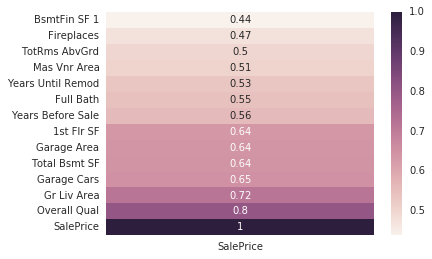

In [18]:
sns.heatmap(abs_corr_coeffs[abs_corr_coeffs>0.4].to_frame(), annot=True)

In [19]:
# Drop columns that have NO higher than 0.4 coefficiencies with the target column
transform_df = transform_df.drop(abs_corr_coeffs[abs_corr_coeffs <= 0.4].index, axis=1)

Which categorical columns should we keep? 

In [20]:
# Create a list of columns names that are categorical columns based on the documentation.
nominal_features = nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]


* Which columns are currently numerical but need to be encoded as categorical instead (because the numbers do not have any semantic meaning)?
* If a categorical column has hundreds of unique values (or categories), should we keep it? When we dummy code this column, hundreds of columns will need to be added back to the data frame.

In [21]:
# Figure out which categorical columns are still with us
transform_cat_cols=[]
for i in transform_df.columns:
    if i in nominal_features:
        transform_cat_cols.append(i)
transform_cat_cols

['MS Zoning',
 'Street',
 'Land Contour',
 'Lot Config',
 'Neighborhood',
 'Condition 1',
 'Condition 2',
 'Bldg Type',
 'House Style',
 'Roof Style',
 'Roof Matl',
 'Exterior 1st',
 'Exterior 2nd',
 'Foundation',
 'Heating',
 'Central Air',
 'Sale Type',
 'Sale Condition']

In [22]:
# How many unique values in each categorical columns?
unique_counts = transform_df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()

In [23]:
unique_counts

Street             2
Central Air        2
Land Contour       4
Lot Config         5
Bldg Type          5
Sale Condition     6
Heating            6
Foundation         6
Roof Style         6
MS Zoning          7
Roof Matl          8
Condition 2        8
House Style        8
Condition 1        9
Sale Type         10
Exterior 1st      16
Exterior 2nd      17
Neighborhood      28
dtype: int64

In [25]:
# Drop the columns with more than 10 unique values
non_unique_cols = unique_counts[unique_counts>10].index
transform_df = transform_df.drop(non_unique_cols, axis=1)

In [30]:
# Convert the remaining text columns to categorical
text_cols = transform_df.select_dtypes(include=['object'])
for col in text_cols:
    transform_df[col] = transform_df[col].astype('category')
# Create dummy columns and add back to the dataframe
transform_df = pd.concat([transform_df, pd.get_dummies(transform_df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)

Update select_features()

In [45]:
def transform_features(data):
    num_missing = data.isnull().sum()
    drop_cols_1 = num_missing[num_missing/len(data) > 0.05]
    data = data.drop(drop_cols_1.index, axis=1)
    
    text_missing = data.select_dtypes(include=['object']).isnull().sum()
    drop_cols_2 = text_missing[text_missing>0]
    data = data.drop(drop_cols_2.index, axis=1)
    
    num_missing = data.select_dtypes(include=['int', 'float']).isnull().sum()
    fixable_numeric_cols = num_missing[(num_missing/len(data)<0.05) & (num_missing>0)].sort_values()
    replacement_values_dict = data[fixable_numeric_cols.index].mode().to_dict(orient='records')[0]
    data = data.fillna(replacement_values_dict)
    
    years_sold = data['Yr Sold'] - data['Year Built']
    year_until_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_sold
    data['Years Until Remod'] = year_until_remod
    data = data.drop([1702, 2180, 2181], axis=0)
    data = data.drop(['Year Built', 'Year Remod/Add'], axis=1)
    
    return data

def select_features(df, coeff_threshold=0.4, uniq_threshold=10):
    numerical_df = df.select_dtypes(include=['int', 'float'])
    abs_corr_coeffs = numerical_df.corr()['SalePrice'].abs().sort_values()
    df = df.drop(abs_corr_coeffs[abs_corr_coeffs <= coeff_threshold].index, axis=1)
    
    nominal_features = ["PID", "MS SubClass", "MS Zoning", "Street", "Alley", "Land Contour", "Lot Config", "Neighborhood", 
                    "Condition 1", "Condition 2", "Bldg Type", "House Style", "Roof Style", "Roof Matl", "Exterior 1st", 
                    "Exterior 2nd", "Mas Vnr Type", "Foundation", "Heating", "Central Air", "Garage Type", 
                    "Misc Feature", "Sale Type", "Sale Condition"]
    
    transform_cat_cols = []
    for col in nominal_features:
        if col in df.columns:
            transform_cat_cols.append(col)
    
    unique_counts = df[transform_cat_cols].apply(lambda col: len(col.value_counts())).sort_values()
    non_unique_cols = unique_counts[unique_counts>uniq_threshold].index
    transform_df = df.drop(non_unique_cols, axis=1)
    
    text_cols = transform_df.select_dtypes(include=['object'])
    for col in text_cols:
        df[col] = df[col].astype('category')
    df= pd.concat([transform_df, pd.get_dummies(df.select_dtypes(include=['category']))], axis=1).drop(text_cols,axis=1)
    return df

def train_and_test(df, k=0):
    numeric_df = df.select_dtypes(include=['int', 'float'])
    features = numeric_df.columns.drop('SalePrice')
    lr = linear_model.LinearRegression()
    if k ==0:
        train = data.iloc[:1460]
        test = data.iloc[1460:]

        numeric_train = train.select_dtypes(include=['integer', 'float'])
        numeric_test = test.select_dtypes(include=['integer', 'float'])
    
        lr = lr.fit(train[features], train['SalePrice'])
        test_predictions = lr.predict(test[features])
        mse_test = mean_squared_error(test_predictions, test['SalePrice'])
        rmse_test = np.sqrt(mse_test)
        return rmse_test
    
    if k==1:
        # Randomize *all* rows (frac=1) from `df` and return
        shuffled_df = data.sample(frac=1, )
        train = df[:1460]
        test = shuffled_df[1460:]
        
        lr.fit(train[features], train["SalePrice"])
        predictions_one = lr.predict(test[features])        
        
        mse_one = mean_squared_error(test["SalePrice"], predictions_one)
        rmse_one = np.sqrt(mse_one)
        
        lr.fit(test[features], test["SalePrice"])
        predictions_two = lr.predict(train[features])        
       
        mse_two = mean_squared_error(train["SalePrice"], predictions_two)
        rmse_two = np.sqrt(mse_two)
        
        avg_rmse = np.mean([rmse_one, rmse_two])
        print(rmse_one)
        print(rmse_two)
        return avg_rmse
    else:
        """implement k-fold cross validation using k folds"""
        kf = KFold(n_splits=k, shuffle=True)
        rmse_values = []
        for train_index, test_index, in kf.split(df):
            train = df.iloc[train_index]
            test = df.iloc[test_index]
            lr.fit(train[features], train["SalePrice"])
            predictions = lr.predict(test[features])
            mse = mean_squared_error(test["SalePrice"], predictions)
            rmse = np.sqrt(mse)
            rmse_values.append(rmse)
        print(rmse_values)
        avg_rmse = np.mean(rmse_values)
        return avg_rmse
    
df = pd.read_csv("AmesHousing.tsv", delimiter="\t")
transform_df = transform_features(df)
filtered_df = select_features(transform_df)
rmse = train_and_test(filtered_df, k=4)

rmse

[39531.32132969944, 34771.61723914079, 28947.7297239262, 29679.62678945643]


33232.57377055572

## Future work
* Continue iteration on feature engineering:
    * Research some other approaches to feature engineering online around housing data.
    * Visit the [Kaggle kernels page](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/kernels) for this dataset
* Improve the feature selection:
    * Research ways of doing feature selection better with categorical columns.